In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import pickle

In [2]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)

In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_dim, dropout=0.5):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(786816, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 2)
    
    def forward(self, X):
        out = X.view(X.size(0), -1)
        out = self.dropout(torch.relu(self.fc1(out)))
        out = self.dropout(torch.relu(self.fc2(out)))
        out = self.dropout(torch.relu(self.fc3(out)))
        out = torch.log_softmax(self.fc4(out), 1)
        return out

In [4]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True,isVal=False):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.isVal = isVal
        if isVal:
            self.testX = torch.from_numpy(np.asarray(data,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(labels,dtype=np.uint8)).type('torch.LongTensor')
        else:
            self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        if self.isVal:
            d = self.data
            l = self.labels
            self.testX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
            return
        d = np.empty((0,3,384,683),int)
        l = []
        for i in range(5):
            if i != testI:
                d = np.append(d,self.data[i],axis=0)
                l += self.labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [5]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    cc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

Batch Size: 48
Weight Decay: 1.1101254708379769
Hidden Dimension: 212
Dropout: 0.02630191277913222

Fold 1
Epoch Train Loss: 0.692161  Epoch Train Accuracy: 54.486715  Epoch Test Loss: 0.831797  Epoch Test Accuracy: 45.766129
Epoch Train Loss: 0.679234  Epoch Train Accuracy: 57.095411  Epoch Test Loss: 0.718227  Epoch Test Accuracy: 41.397849
Epoch Train Loss: 0.681195  Epoch Train Accuracy: 56.099034  Epoch Test Loss: 0.691088  Epoch Test Accuracy: 43.766801
Epoch Train Loss: 0.686376  Epoch Train Accuracy: 54.547101  Epoch Test Loss: 0.691552  Epoch Test Accuracy: 40.641801
Epoch Train Loss: 0.688040  Epoch Train Accuracy: 59.148551  Epoch Test Loss: 0.690174  Epoch Test Accuracy: 46.522177
Epoch Train Loss: 0.690103  Epoch Train Accuracy: 57.892512  Epoch Test Loss: 0.693083  Epoch Test Accuracy: 42.540323
Epoch Train Loss: 0.691463  Epoch Train Accuracy: 56.805556  Epoch Test Loss: 0.692959  Epoch Test Accuracy: 50.453629
Epoch Train Loss: 0.692654  Epoch Train Accuracy: 50.954106 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Fold 2
Epoch Train Loss: 2.310212  Epoch Train Accuracy: 51.648352  Epoch Test Loss: 2.116190  Epoch Test Accuracy: 48.863636
Epoch Train Loss: 2.076777  Epoch Train Accuracy: 48.443223  Epoch Test Loss: 2.047786  Epoch Test Accuracy: 48.208042
Epoch Train Loss: 1.534262  Epoch Train Accuracy: 51.236264  Epoch Test Loss: 1.343397  Epoch Test Accuracy: 52.753497
Epoch Train Loss: 0.900934  Epoch Train Accuracy: 47.435897  Epoch Test Loss: 0.944893  Epoch Test Accuracy: 43.706294
Epoch Train Loss: 0.729342  Epoch Train Accuracy: 51.282051  Epoch Test Loss: 0.835798  Epoch Test Accuracy: 56.293706
Epoch Train Loss: 0.725935  Epoch Train Accuracy: 50.686813  Epoch Test Loss: 0.745676  Epoch Test Accuracy: 46.284965
Epoch Train Loss: 0.713990  Epoch Train Accuracy: 50.595238  Epoch Test Loss: 0.710398  Epoch Test Accuracy: 43.312937
Epoch Train Loss: 0.709214  Epoch Train Accuracy: 50.320513  Epoch Test Loss: 0.693767  Epoch Test Accuracy: 50.655594
Epoch Train Loss: 0.693516  Epoch Train A

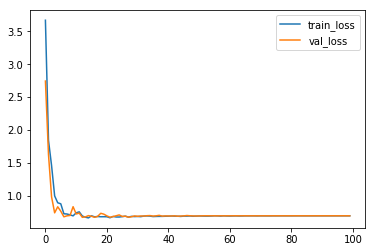

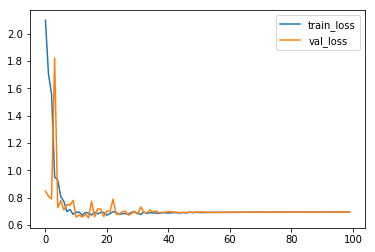

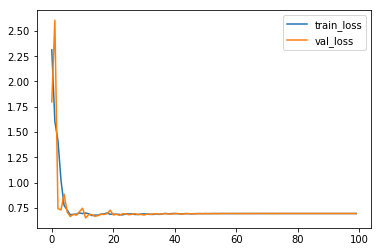

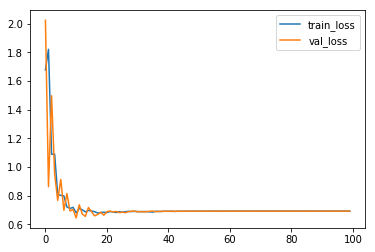

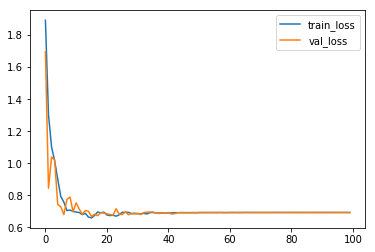

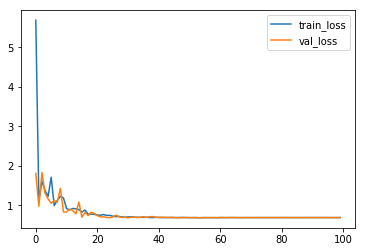

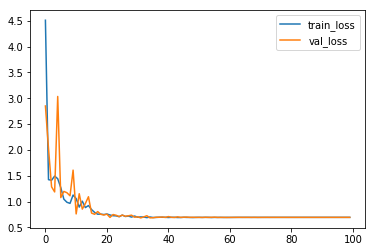

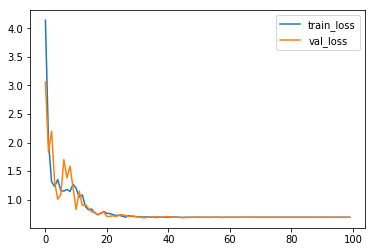

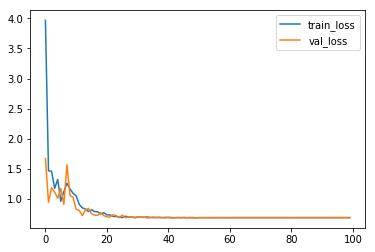

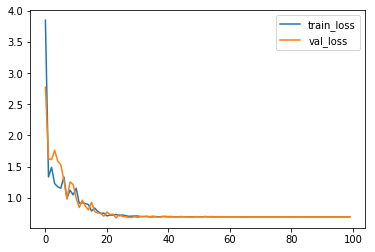

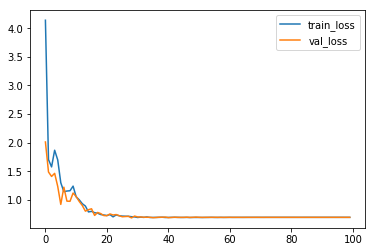

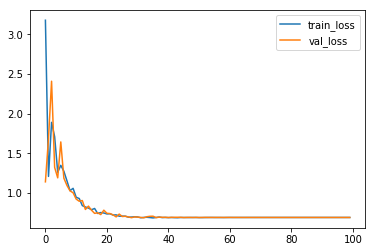

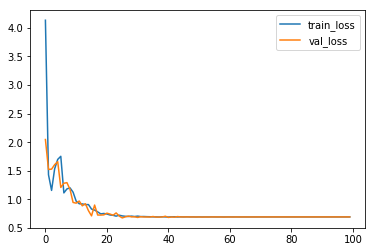

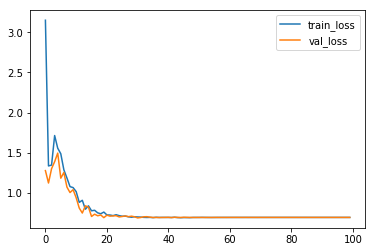

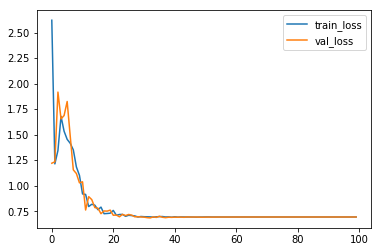

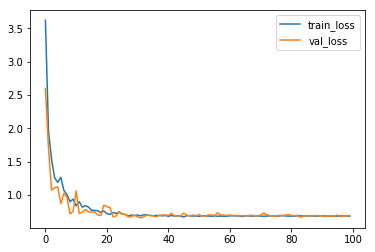

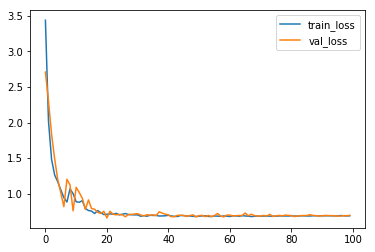

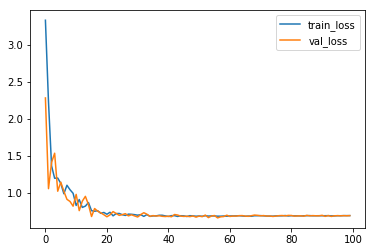

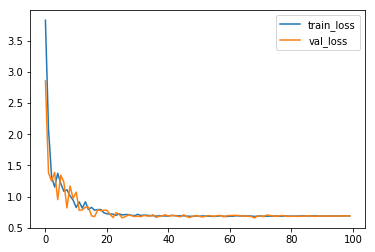

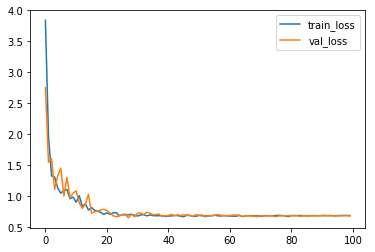

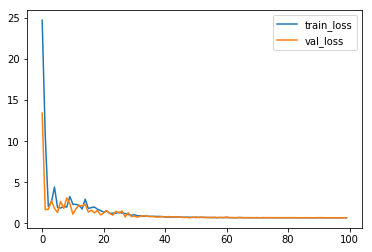

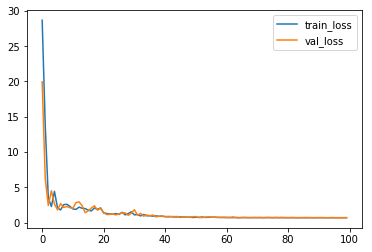

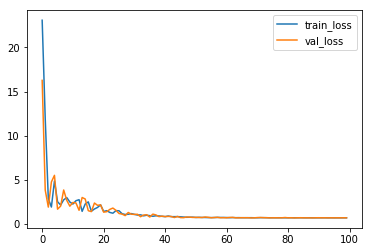

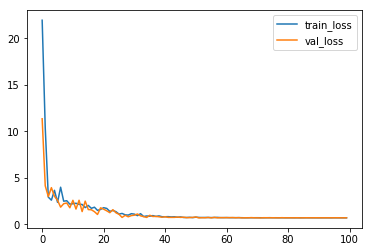

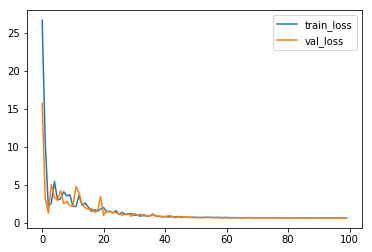

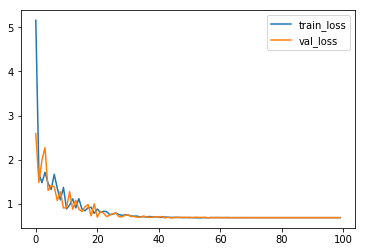

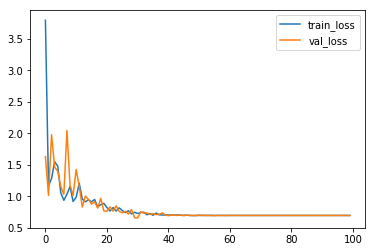

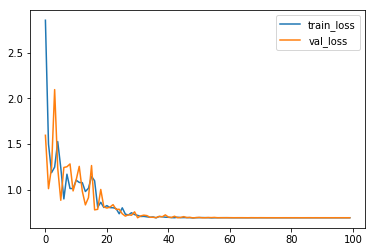

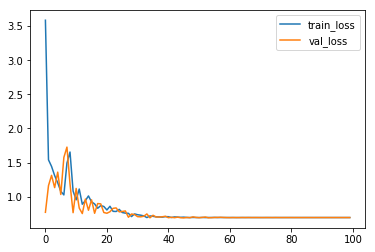

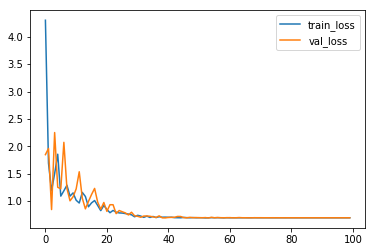

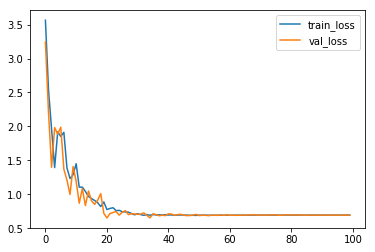

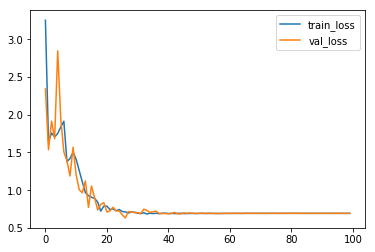

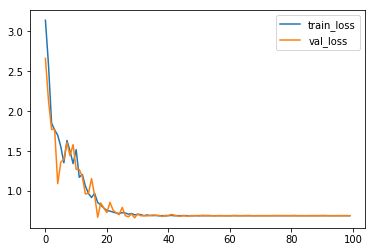

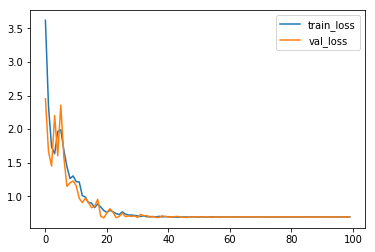

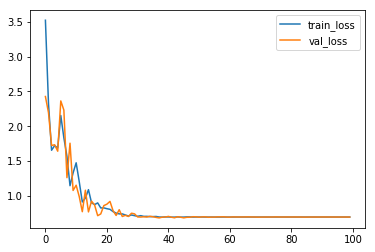

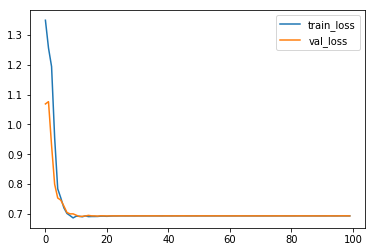

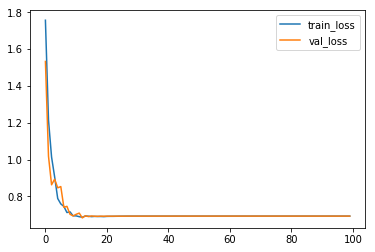

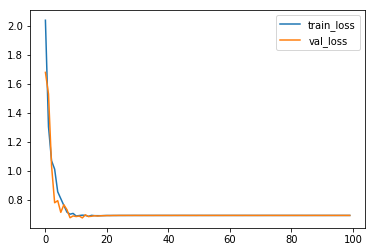

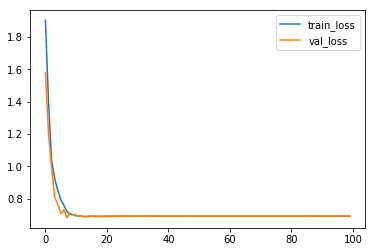

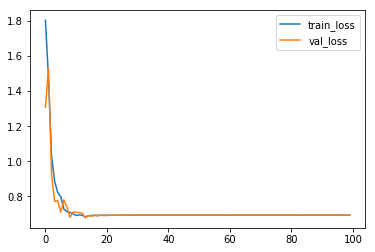

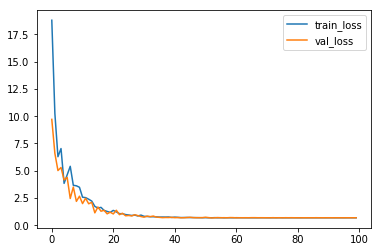

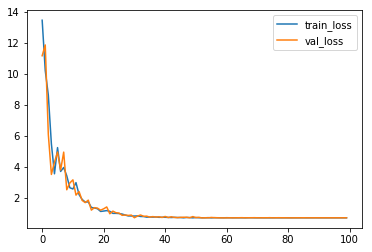

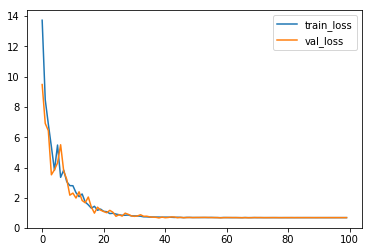

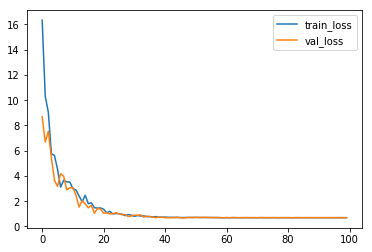

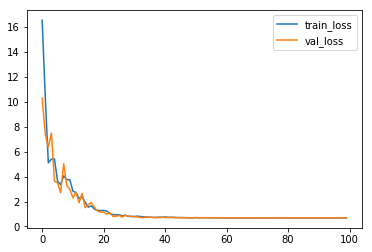

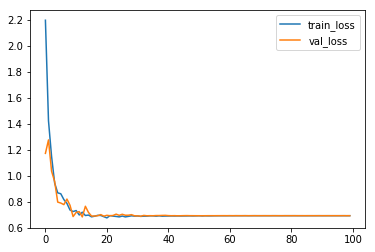

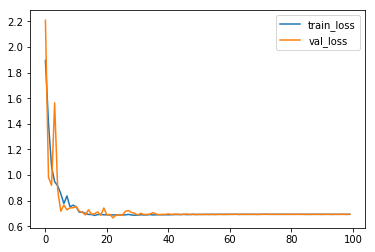

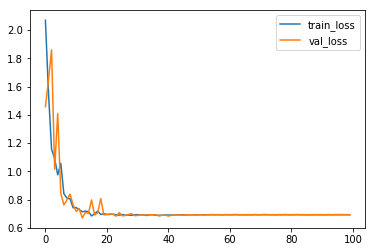

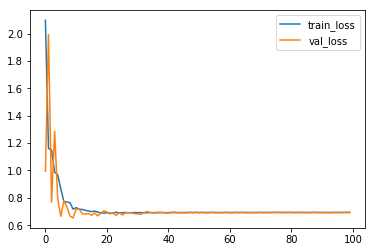

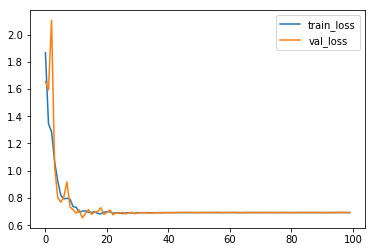

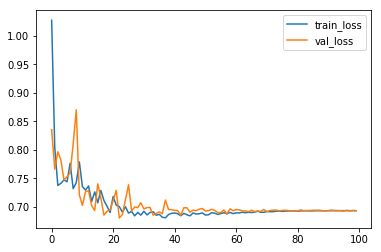

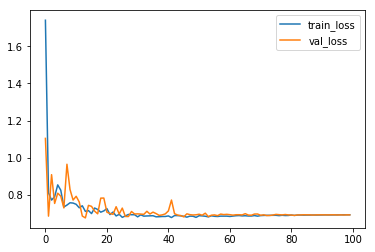

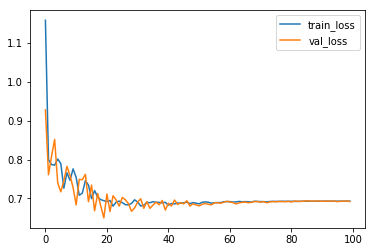

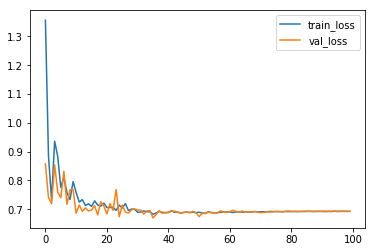

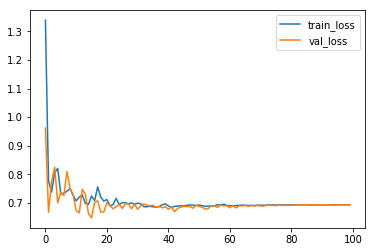

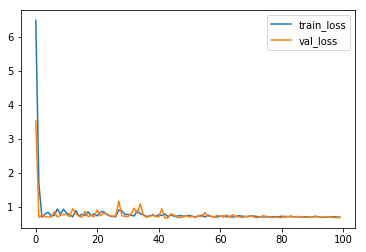

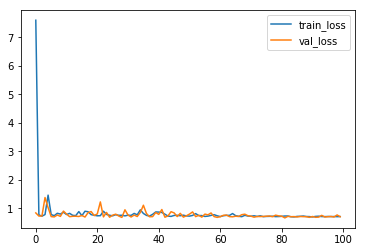

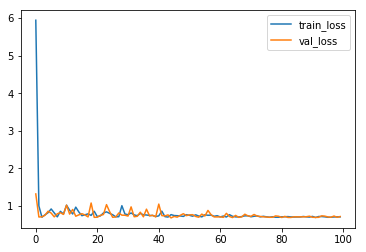

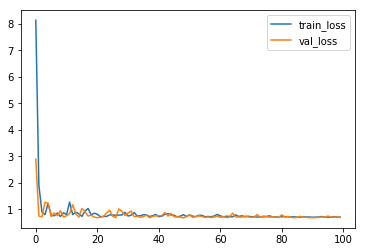

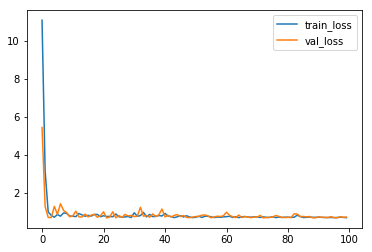

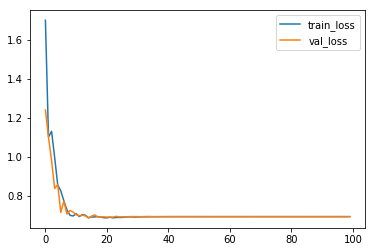

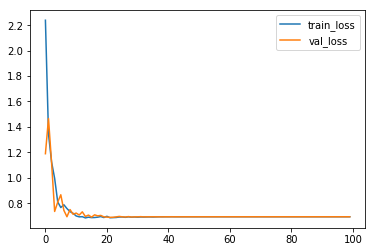

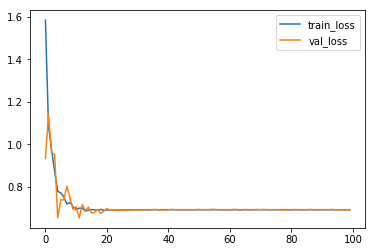

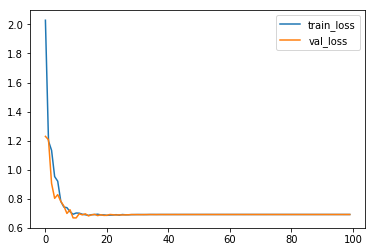

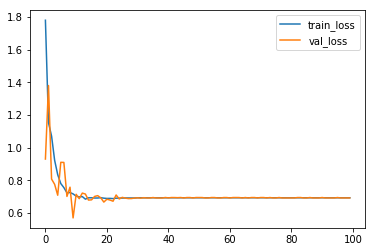

In [6]:
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

num_attempts = 13

random.seed(4815162352)
batch_sizes = [int(np.round(2 ** random.uniform(5,8))) for i in range(num_attempts)]
dropouts = [random.uniform(0,0.9) for i in range(num_attempts)]
weight_decays = [np.exp(random.normalvariate(0,0.5)) for i in range(num_attempts)]
hidden_dims = [int(np.round(2 ** random.uniform(6,8))) for i in range(num_attempts)]
stats = []
fbs,fwd,fhd,fd = 0,0,0,0
best_acc = -999

disable = True
epochs = 100
every_other = 10

for i in range(len(batch_sizes)):
    avedloss, avedacc, avevloss, avevacc = 0,0,0,0
    batch_size = batch_sizes[i]
    weight_decay = weight_decays[i]
    hidden_dim = hidden_dims[i]
    dropout = dropouts[i]
    print("Batch Size: {}\nWeight Decay: {}\nHidden Dimension: {}\nDropout: {}\n".format(batch_size,weight_decay,hidden_dim,dropout))
    for i in range(5):
        torch.manual_seed(4815162342)
        model = MLP(hidden_dim=hidden_dim, dropout=dropout).cuda()
        optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        dlosscurve = []
        dacccurve = []
        vlosscurve = []
        vacccurve = []
        print("Fold %d" % (i + 1))
        my_data.setTest(i)
        my_test.setTest(i)

        my_loader = DataLoader(my_data, batch_size=batch_size,
                                shuffle=True)
        my_test_loader = DataLoader(my_test, batch_size=batch_size,
                                shuffle=True)
        for j in range(epochs):
            dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
            vloss, vacc = test(model,criterion,my_test_loader,disable)
            dlosscurve.append(dloss)
            dacccurve.append(dacc)
            vlosscurve.append(vloss)
            vacccurve.append(vacc)
            if j % every_other == every_other - 1:
                print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
        df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
        df.plot.line()
        avedloss += dloss
        avedacc += dacc
        avevloss += vloss
        avevacc += vacc
    avedloss /= 5
    avedacc /= 0.05
    avevloss /= 5
    avevacc /= 0.05
    if avevacc > best_acc:
        fbs,fwd,fhd,fd,best_acc = batch_size, weight_decay, hidden_dim, dropout, avevacc
    print("Batch Size: {}\nWeight Decay: {}\nHidden Dimension: {}\nDropout: {}\n".format(batch_size,weight_decay,hidden_dim,dropout))
    print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))
    stats.append([avedloss,avedacc,avevloss,avevacc])

In [7]:
for i in range(len(stats)):
    print("{} & {:.2f} & {} & {:.2f} & {} \\\\ \\hline".format(batch_sizes[i],weight_decays[i],hidden_dims[i],dropouts[i]," & ".join(["{:.2f}{}".format(stats[i][j],"\\%" if j % 2 == 1 else "") for j in range(len(stats[i]))])))
# hyperparameters
batch_size = fbs
weight_decay = fwd
dropout = fd
disable = False
epochs = 100
every_other = 10

# initializing training objects
torch.manual_seed(4815162342)
model = MLP(hidden_dim=hidden_dim, dropout=dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# initializing dataset
my_data = AutoUXDataset(data,labels,True)
my_val = AutoUXDataset(dataVal,labelsVal,False,True)
my_loader = DataLoader(my_data, batch_size=batch_size,shuffle=True)
my_val_loader = DataLoader(my_val, batch_size=batch_size,shuffle=True)
my_data.setTest(-1)
my_val.setTest(-1)

# initializing tracking variables
dlosscurve = []
dacccurve = []
vlosscurve = []
vacccurve = []

# training loop
for j in range(epochs):
    dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
    vloss, vacc = test(model,criterion,my_val_loader,disable)
    dlosscurve.append(dloss)
    dacccurve.append(dacc)
    vlosscurve.append(vloss)
    vacccurve.append(vacc)
    if j % every_other == every_other - 1:
        print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))

print("Batch Size: {}\nWeight Decay: {}\nHidden Dimensions: {}\nDropout: {}\n".format(batch_size,weight_decay,hidden_dim,dropout))
print("Train Loss: {:.6f}\nTrain Accuracy: {:.6f}\nValidation Loss: {:.6f}\nValidation Accuracy: {:.6f}\n".format(dloss,dacc * 100,vloss,vacc * 100))
print("{} & {:.2f} & {} & {:.2f} & {:.2f} & {:.2f}\% & {:.2f} & {:.2f}\% \\\\ \\hline".format(batch_size,weight_decay,hidden_dim,dropout,dloss,dacc * 100,vloss, vacc * 100))

48 & 1.11 & 212 & 0.03 & 0.69 & 50.69\% & 0.69 & 51.48\% \\ \hline
37 & 0.80 & 76 & 0.47 & 0.69 & 50.52\% & 0.69 & 50.41\% \\ \hline
97 & 1.59 & 128 & 0.51 & 0.69 & 50.22\% & 0.69 & 51.15\% \\ \hline
85 & 0.58 & 177 & 0.31 & 0.69 & 56.80\% & 0.69 & 55.63\% \\ \hline
52 & 1.21 & 174 & 0.77 & 0.69 & 52.00\% & 0.69 & 52.52\% \\ \hline
113 & 2.19 & 76 & 0.61 & 0.69 & 50.57\% & 0.69 & 51.29\% \\ \hline
162 & 1.66 & 210 & 0.57 & 0.69 & 51.25\% & 0.69 & 55.60\% \\ \hline
49 & 1.76 & 204 & 0.31 & 0.69 & 50.58\% & 0.69 & 51.70\% \\ \hline
50 & 1.16 & 229 & 0.71 & 0.69 & 51.70\% & 0.69 & 49.51\% \\ \hline
44 & 0.77 & 167 & 0.21 & 0.69 & 50.70\% & 0.69 & 46.36\% \\ \hline
146 & 1.64 & 66 & 0.25 & 0.69 & 50.74\% & 0.69 & 54.09\% \\ \hline
189 & 0.56 & 64 & 0.68 & 0.71 & 49.70\% & 0.71 & 51.25\% \\ \hline
60 & 1.26 & 226 & 0.21 & 0.69 & 50.75\% & 0.69 & 55.50\% \\ \hline


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


Epoch Train Loss: 0.841374  Epoch Train Accuracy: 49.148116  Epoch Test Loss: 0.805771  Epoch Test Accuracy: 46.666667


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Epoch Train Loss: 0.703668  Epoch Train Accuracy: 50.013680  Epoch Test Loss: 0.671077  Epoch Test Accuracy: 60.000000


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Epoch Train Loss: 0.690229  Epoch Train Accuracy: 51.819425  Epoch Test Loss: 0.671608  Epoch Test Accuracy: 57.777778


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.73it/s]


Epoch Train Loss: 0.687195  Epoch Train Accuracy: 55.764208  Epoch Test Loss: 0.707570  Epoch Test Accuracy: 44.444444


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.07it/s]


Epoch Train Loss: 0.689296  Epoch Train Accuracy: 55.212038  Epoch Test Loss: 0.692336  Epoch Test Accuracy: 57.777778


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.74it/s]


Epoch Train Loss: 0.690632  Epoch Train Accuracy: 58.562368  Epoch Test Loss: 0.691466  Epoch Test Accuracy: 53.333333


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.17it/s]


Epoch Train Loss: 0.690105  Epoch Train Accuracy: 58.229076  Epoch Test Loss: 0.691176  Epoch Test Accuracy: 57.777778


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.75it/s]


Epoch Train Loss: 0.691958  Epoch Train Accuracy: 53.306803  Epoch Test Loss: 0.692127  Epoch Test Accuracy: 55.555556


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch Train Loss: 0.692768  Epoch Train Accuracy: 49.909215  Epoch Test Loss: 0.694624  Epoch Test Accuracy: 42.222222


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


Epoch Train Loss: 0.693010  Epoch Train Accuracy: 50.538490  Epoch Test Loss: 0.694306  Epoch Test Accuracy: 44.444444
Batch Size: 85
Weight Decay: 0.5810997433816847
Hidden Dimensions: 226
Dropout: 0.3141277235183339

Train Loss: 0.693010
Train Accuracy: 50.538490
Validation Loss: 0.694306
Validation Accuracy: 44.444444

85 & 0.58 & 226 & 0.31 & 0.69 & 50.54\% & 0.69 & 44.44\% \\ \hline


In [ ]:
answers = np.array([])
preds = np.array([])
with torch.no_grad():
    for s in tqdm(my_val,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
        preds = np.append(preds,torch.max(y_pred,1)[1])
answers = np.exp(answers)
print(answers)
print(preds)

In [ ]:
with open('mlpoutprob.pt', 'wb') as f:
    pickle.dump(answers, f)
with open('mlpout.pt','wb') as f:
    pickle.dump(preds,f)

In [ ]:
from sklearn.metrics import *
import itertools
import pickle
with open('mlpout.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))
